In [ ]:
import sys  
sys.path.insert(1, r'..\..\MetroPT')
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from dataset import MetroPTDataset
from scripts.utils import MODEL_MAP
from torch.nn import functional as F
import lime
import shap
import matplotlib.pyplot as plt
from scripts.lightning_training import Module
from lime import lime_tabular
from lime import submodular_pick
import re
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


# Explaining Failures in MetroPT Dataset

Generating local and global explanations for pytorch deep learning models that predict the Remaining Useful Life of air production units in the Metro do Porto. For implementing the explainers LIME, Shap and TimeShap packages are used.

## Auxiliar funtions

In [2]:
def load_model_from_checkpoint(checkpoint_path):
    model = Module.load_from_checkpoint(checkpoint_path)
    return model

In [3]:
# batch predict funtion for getting explanations of pytorch models with LIME
def batch_predict(data):
    '''
    Wrapper function for LIME explainer usage with Pytorch model. Receives a batch of data, moves both
    model and data to the same device, generates the predictions and move the prediction back to cpu as a 
    numpy array.

    Parameters
    ----------
    data : Tensor
        Batch of input data for the model.

    Returns
    -------
    np.array
        Numpy array with the predictions of the model.

    '''
    model.eval()
 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    data = torch.Tensor(data).to(device)
    
    outputs = model(data)
    return outputs.detach().cpu().numpy()

## Lime

In [4]:
checkpoint_path = r'..\..\checkpoints\model-version_1-10min-w60-last5hours-only-analog\checkpoint-epoch=39-val_rmse=0.7199.ckpt'

In [5]:
model = load_model_from_checkpoint(checkpoint_path)

In [ ]:
def get_lime_explanations(x, y, x_test, feature_names, class_names, model):
    '''
    Function to get LIME explanations for the model predictions
    model: trained model
    x: input data
    y: target data
    feature_names: list of feature names
    class_names: list of class names
    '''
    # Create the LIME recurrent explainer
    explainer = lime_tabular.RecurrentTabularExplainer(x, 
                                                       mode='classification', 
                                                       feature_names=feature_names, 
                                                       training_labels=y, 
                                                       discretize_continuous=True, 
                                                       class_names=class_names)
    # Get the LIME explanations
    explanations = []
    for instance in x_test:
        exp = explainer.explain_instance(instance, batch_predict, num_features=feature_names.shape[0])
        explanations.append(exp)
    return explanations

In [14]:
x, y = MetroPTDataset.get_experiment_dataset_as_tensor(data_dir='../../../../../Datasets/metropt',
            piece_wise_rul=30,
            window_size=30,
            test_pct=0.2,
            validation_rate=0.2,
            index=0)

8 subsets loaded
1 subsets for validation
5 subsets for training
2 subsets for testing
150


In [ ]:
explanations = get_lime_explanations(x, y, x_test[0:1], feature_names, ['NORMAL', 'FAULT'], model)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
explanations[0].as_list()

[('sensor_04_t-1 <= 0.27', 0.009839306317371151),
 ('sensor_42_t-3 <= -0.27', 0.00836077123602288),
 ('sensor_47_t-21 <= -0.50', 0.007854180859957403),
 ('sensor_13_t-53 <= -0.50', 0.007578693219191176),
 ('sensor_44_t-19 <= -0.55', 0.007417200544074388),
 ('sensor_42_t-16 <= -0.27', 0.007289122894510206),
 ('sensor_26_t-43 > 0.65', 0.007231061813184034),
 ('sensor_04_t-4 <= 0.27', 0.00712237496860466),
 ('sensor_29_t-6 <= -0.30', 0.00709749166594999),
 ('sensor_11_t-32 <= -0.13', 0.006921425188716489),
 ('sensor_22_t-52 > 0.52', 0.006898004315226761),
 ('sensor_22_t-10 > 0.52', 0.006892891837684713),
 ('sensor_42_t-7 <= -0.27', 0.006497195121215433),
 ('sensor_12_t-9 <= -0.07', 0.006302778026945218),
 ('sensor_41_t-23 <= -0.37', 0.006230594100959552),
 ('sensor_48_t-18 <= -0.73', 0.005760195338921018),
 ('sensor_11_t-18 <= -0.13', 0.005596904698236838),
 ('sensor_43_t-58 <= -0.33', 0.005440073562260688),
 ('sensor_25_t-1 > 0.58', 0.0053769376496869605),
 ('sensor_11_t-26 <= -0.13', 0.

##### Pick module

In [ ]:
feature_names = ['TP2','TP3','H1','Reservoirs','Oil_temperature','COMP']
feature_names_alt = ['sensor_01','sensor_02','sensor_03','sensor_04','sensor_05','sensor_06']

feature_names_map = {feature_names_alt[index]: f for index, f in enumerate(feature_names)}

In [12]:
feature_names_map

{'sensor_01': 'TP2',
 'sensor_02': 'TP3',
 'sensor_03': 'H1',
 'sensor_04': 'Reservoirs',
 'sensor_05': 'Oil_temperature',
 'sensor_06': 'COMP'}

In [15]:
explainer = lime_tabular.RecurrentTabularExplainer(x,
                                                       mode='regression', 
                                                       feature_names=feature_names_alt, 
                                                       training_labels=y,
                                                       discretize_continuous=False,)

In [17]:
def get_mean_feature_importace_per_feature(explainer, predict_fn, data, num_exps_desired=2, label=1 ):
    '''
    Function to get the mean feature importance for each feature
    explainer: LIME explainer object
    predict_fn: model prediction function
    data: input data
    label: label to explain
    num_exps_desired: number of explanations to get
    '''
    sp_obj = submodular_pick.SubmodularPick(explainer, data=data[:500].numpy(), predict_fn=predict_fn, num_features=(data.shape[1]*data.shape[2]),num_exps_desired=num_exps_desired)
    feature_importance = [ _.as_list(label=label) for _ in sp_obj.sp_explanations]
    _ = []
    for row in feature_importance:
        _.append([ [re.findall(r'sensor_\d+', feature)[0],re.findall(r't-\d+', feature)[0],value] for feature, value in row ] )
    return pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)
    # feature_importance_df = pd.concat([ pd.DataFrame(_[i], columns=['feature','timestamp', 'value'] ) for i in range(len(_)) ], axis=0)
    # return feature_importance_df[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False).reset_index()

In [ ]:
feature_importance_0_1 = get_mean_feature_importace_per_feature(explainer, batch_predict, x[np.where(y<1)], num_exps_desired=10, label=1)
feature_importance_2 = get_mean_feature_importace_per_feature(explainer, batch_predict, x[np.where(y>2)], num_exps_desired=10, label=1)

In [ ]:
feature_importance_0_1_mean = feature_importance_0_1[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance_0_1 = feature_importance_0_1[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

feature_importance_2_mean = feature_importance_2[['feature','value']].groupby('feature').mean().sort_values(by='value', ascending=False)
timesteps_importance_2 = feature_importance_2[['timestamp','value']].groupby('timestamp').mean().sort_values(by='value', ascending=False)

<Axes: xlabel='value', ylabel='feature'>

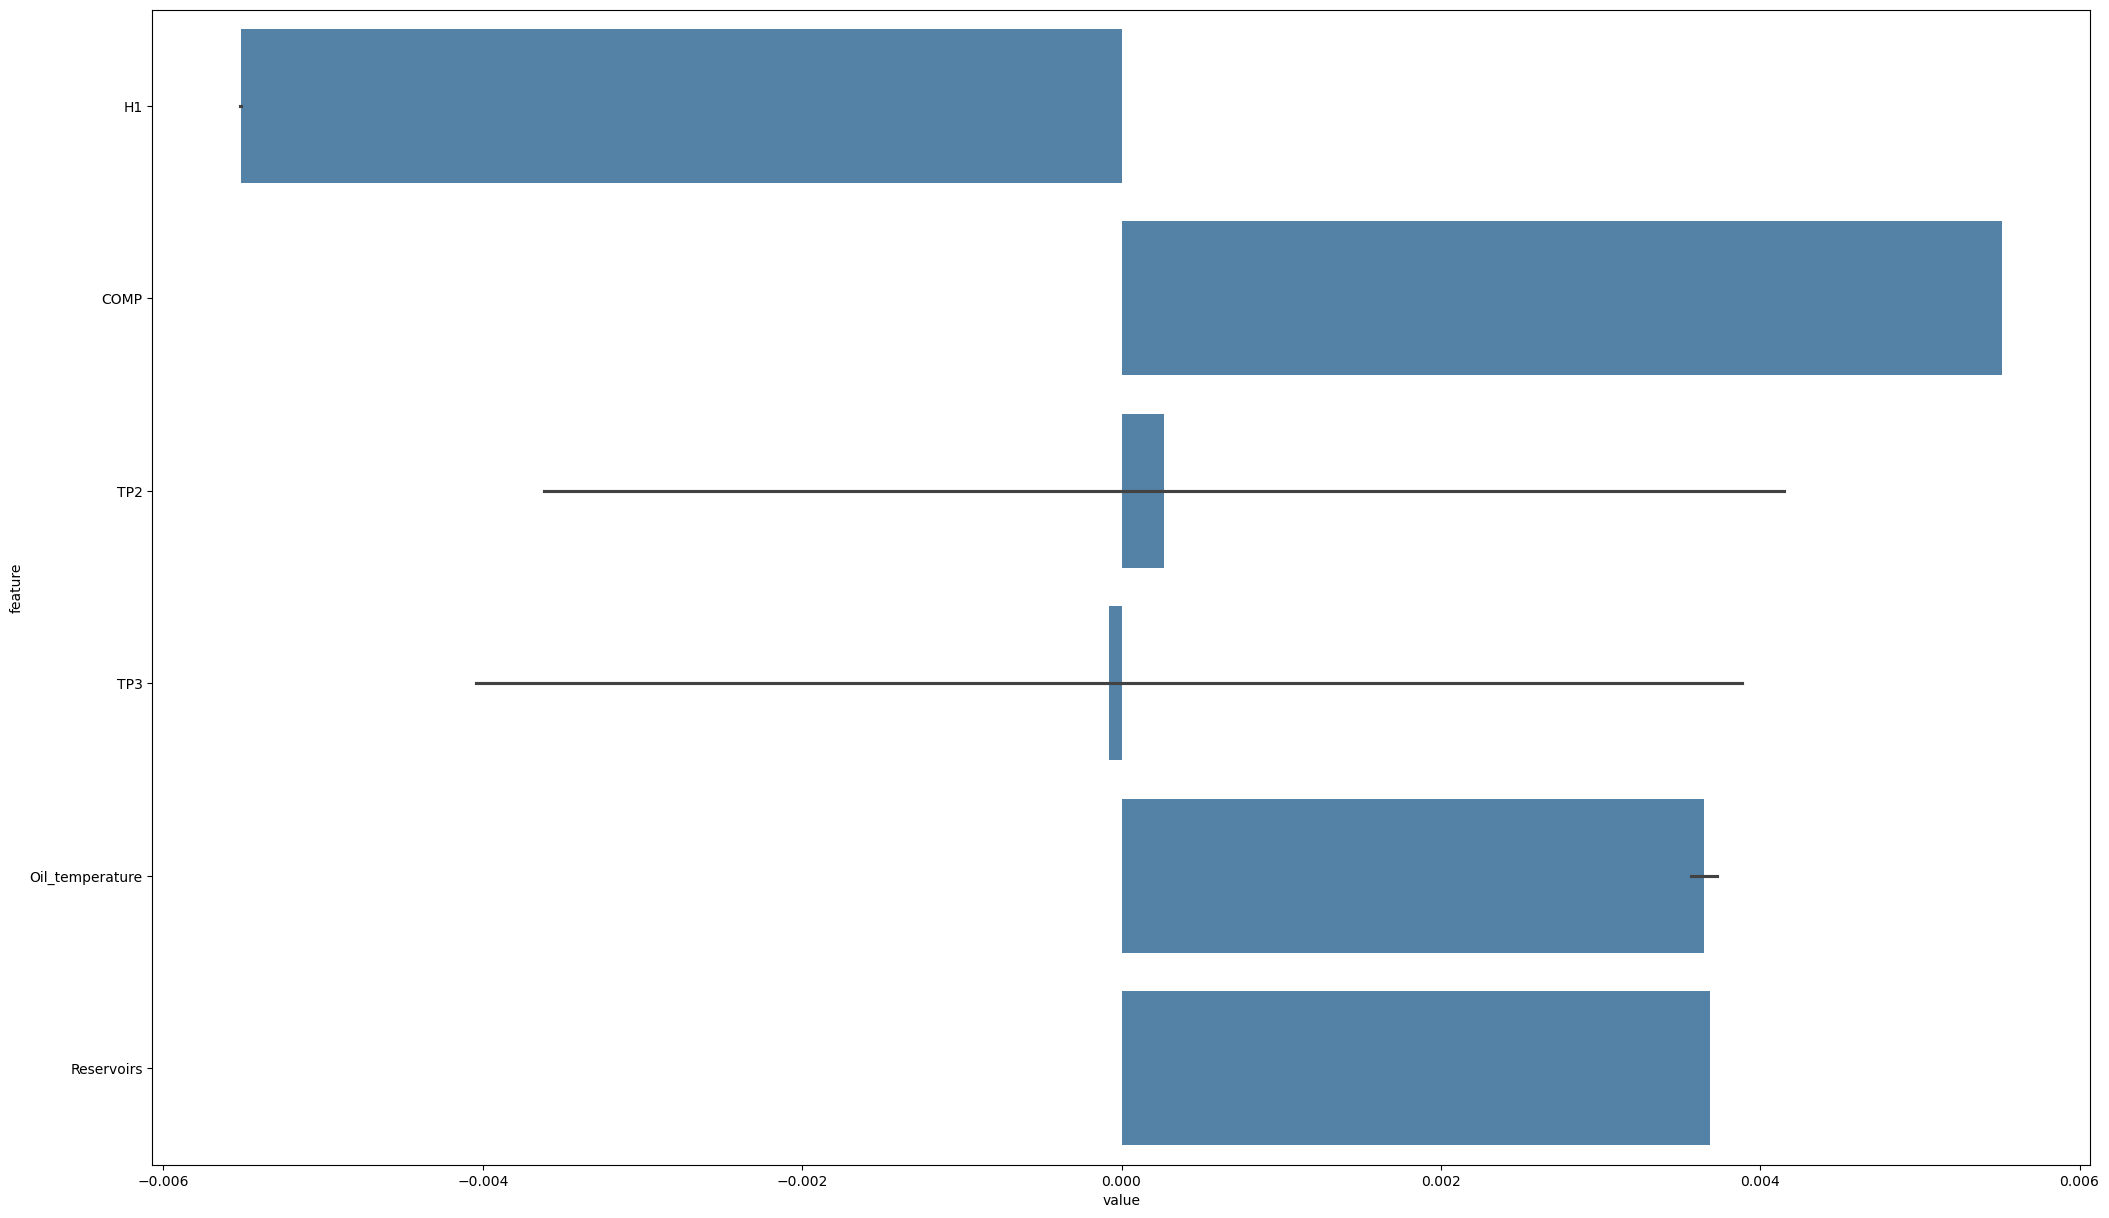

In [21]:
plt.figure(figsize=(25,15))
feature_importance_0_1 = feature_importance_0_1.reset_index()
feature_importance_0_1['feature'] = feature_importance_0_1['feature'].map(feature_names_map)
sns.barplot(x='value', y='feature', data=feature_importance_0_1[:10].reset_index(),orient='h',color='steelblue')
# feature_importance_failures_mean.reset_index(inplace=False)

Text(0, 0.5, 'Feature')

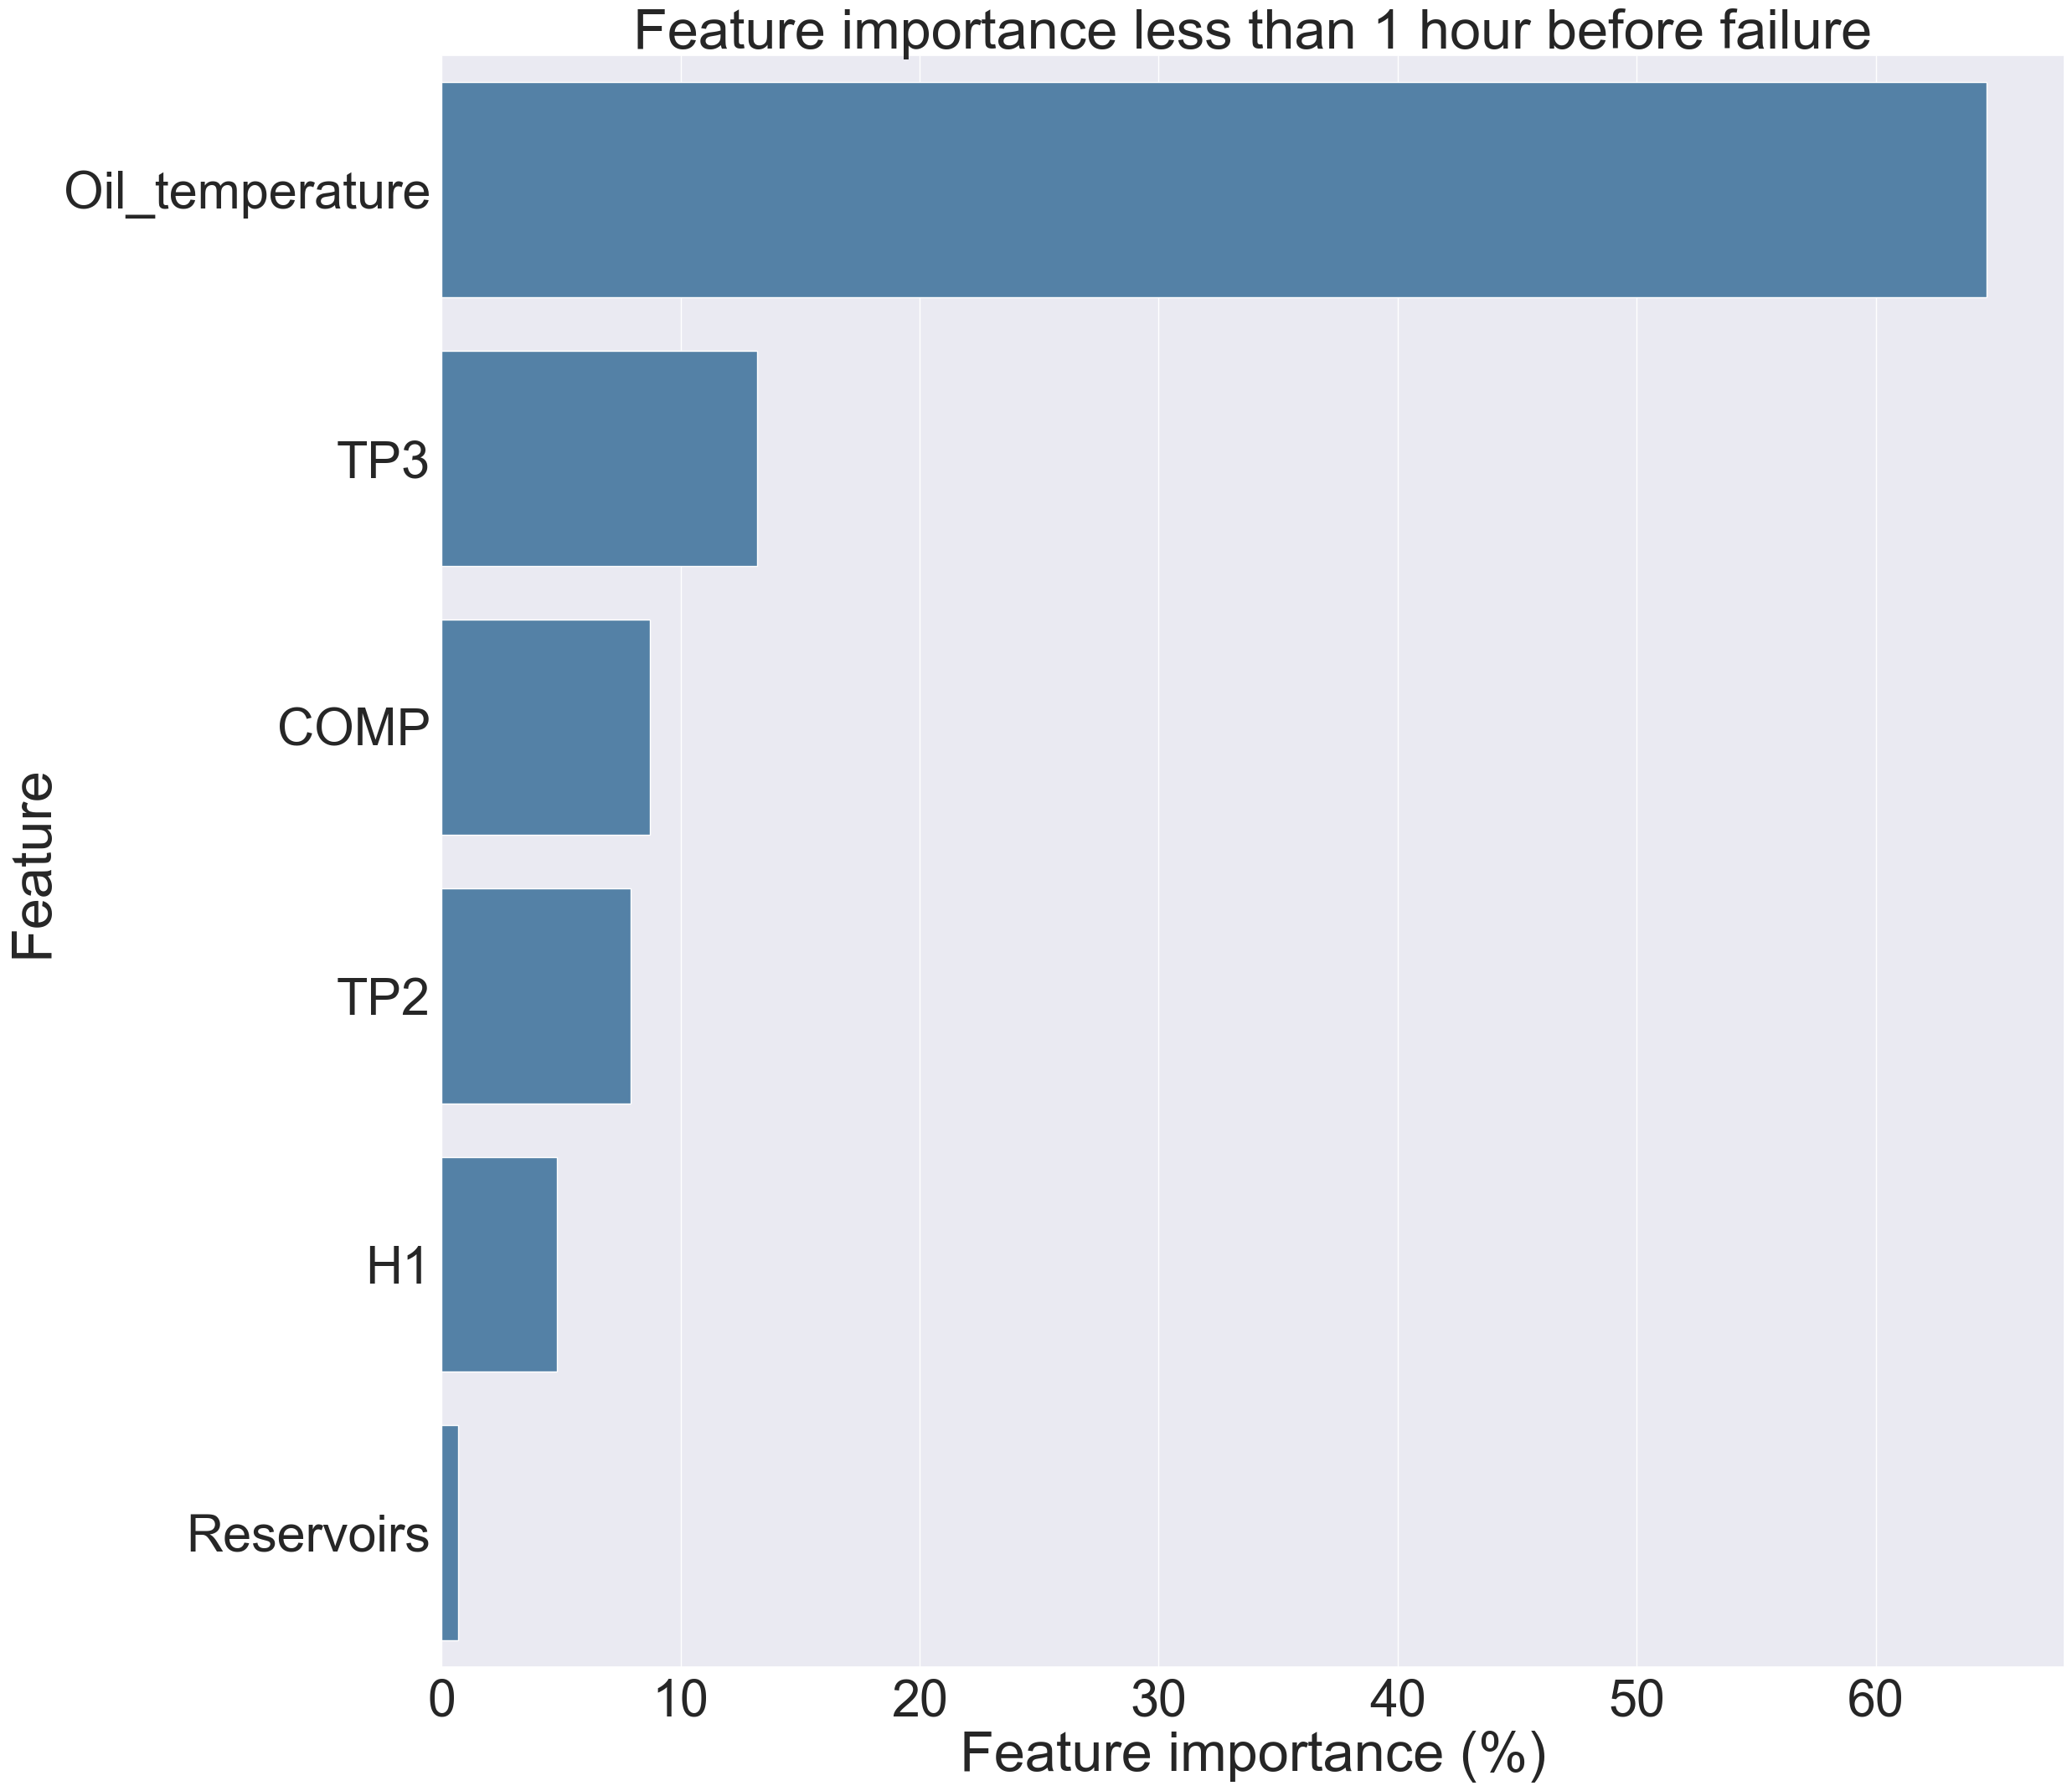

In [80]:
feature_data_for_plot = feature_importance_0_1_mean.reset_index()
feature_data_for_plot['feature'] = feature_data_for_plot['feature'].map(feature_names_map)
feature_data_for_plot['pct'] = (abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()) * 100
sns.set(font_scale=4)
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title('Feature importance less than 1 hour before failure')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]

Text(0, 0.5, 'Feature')

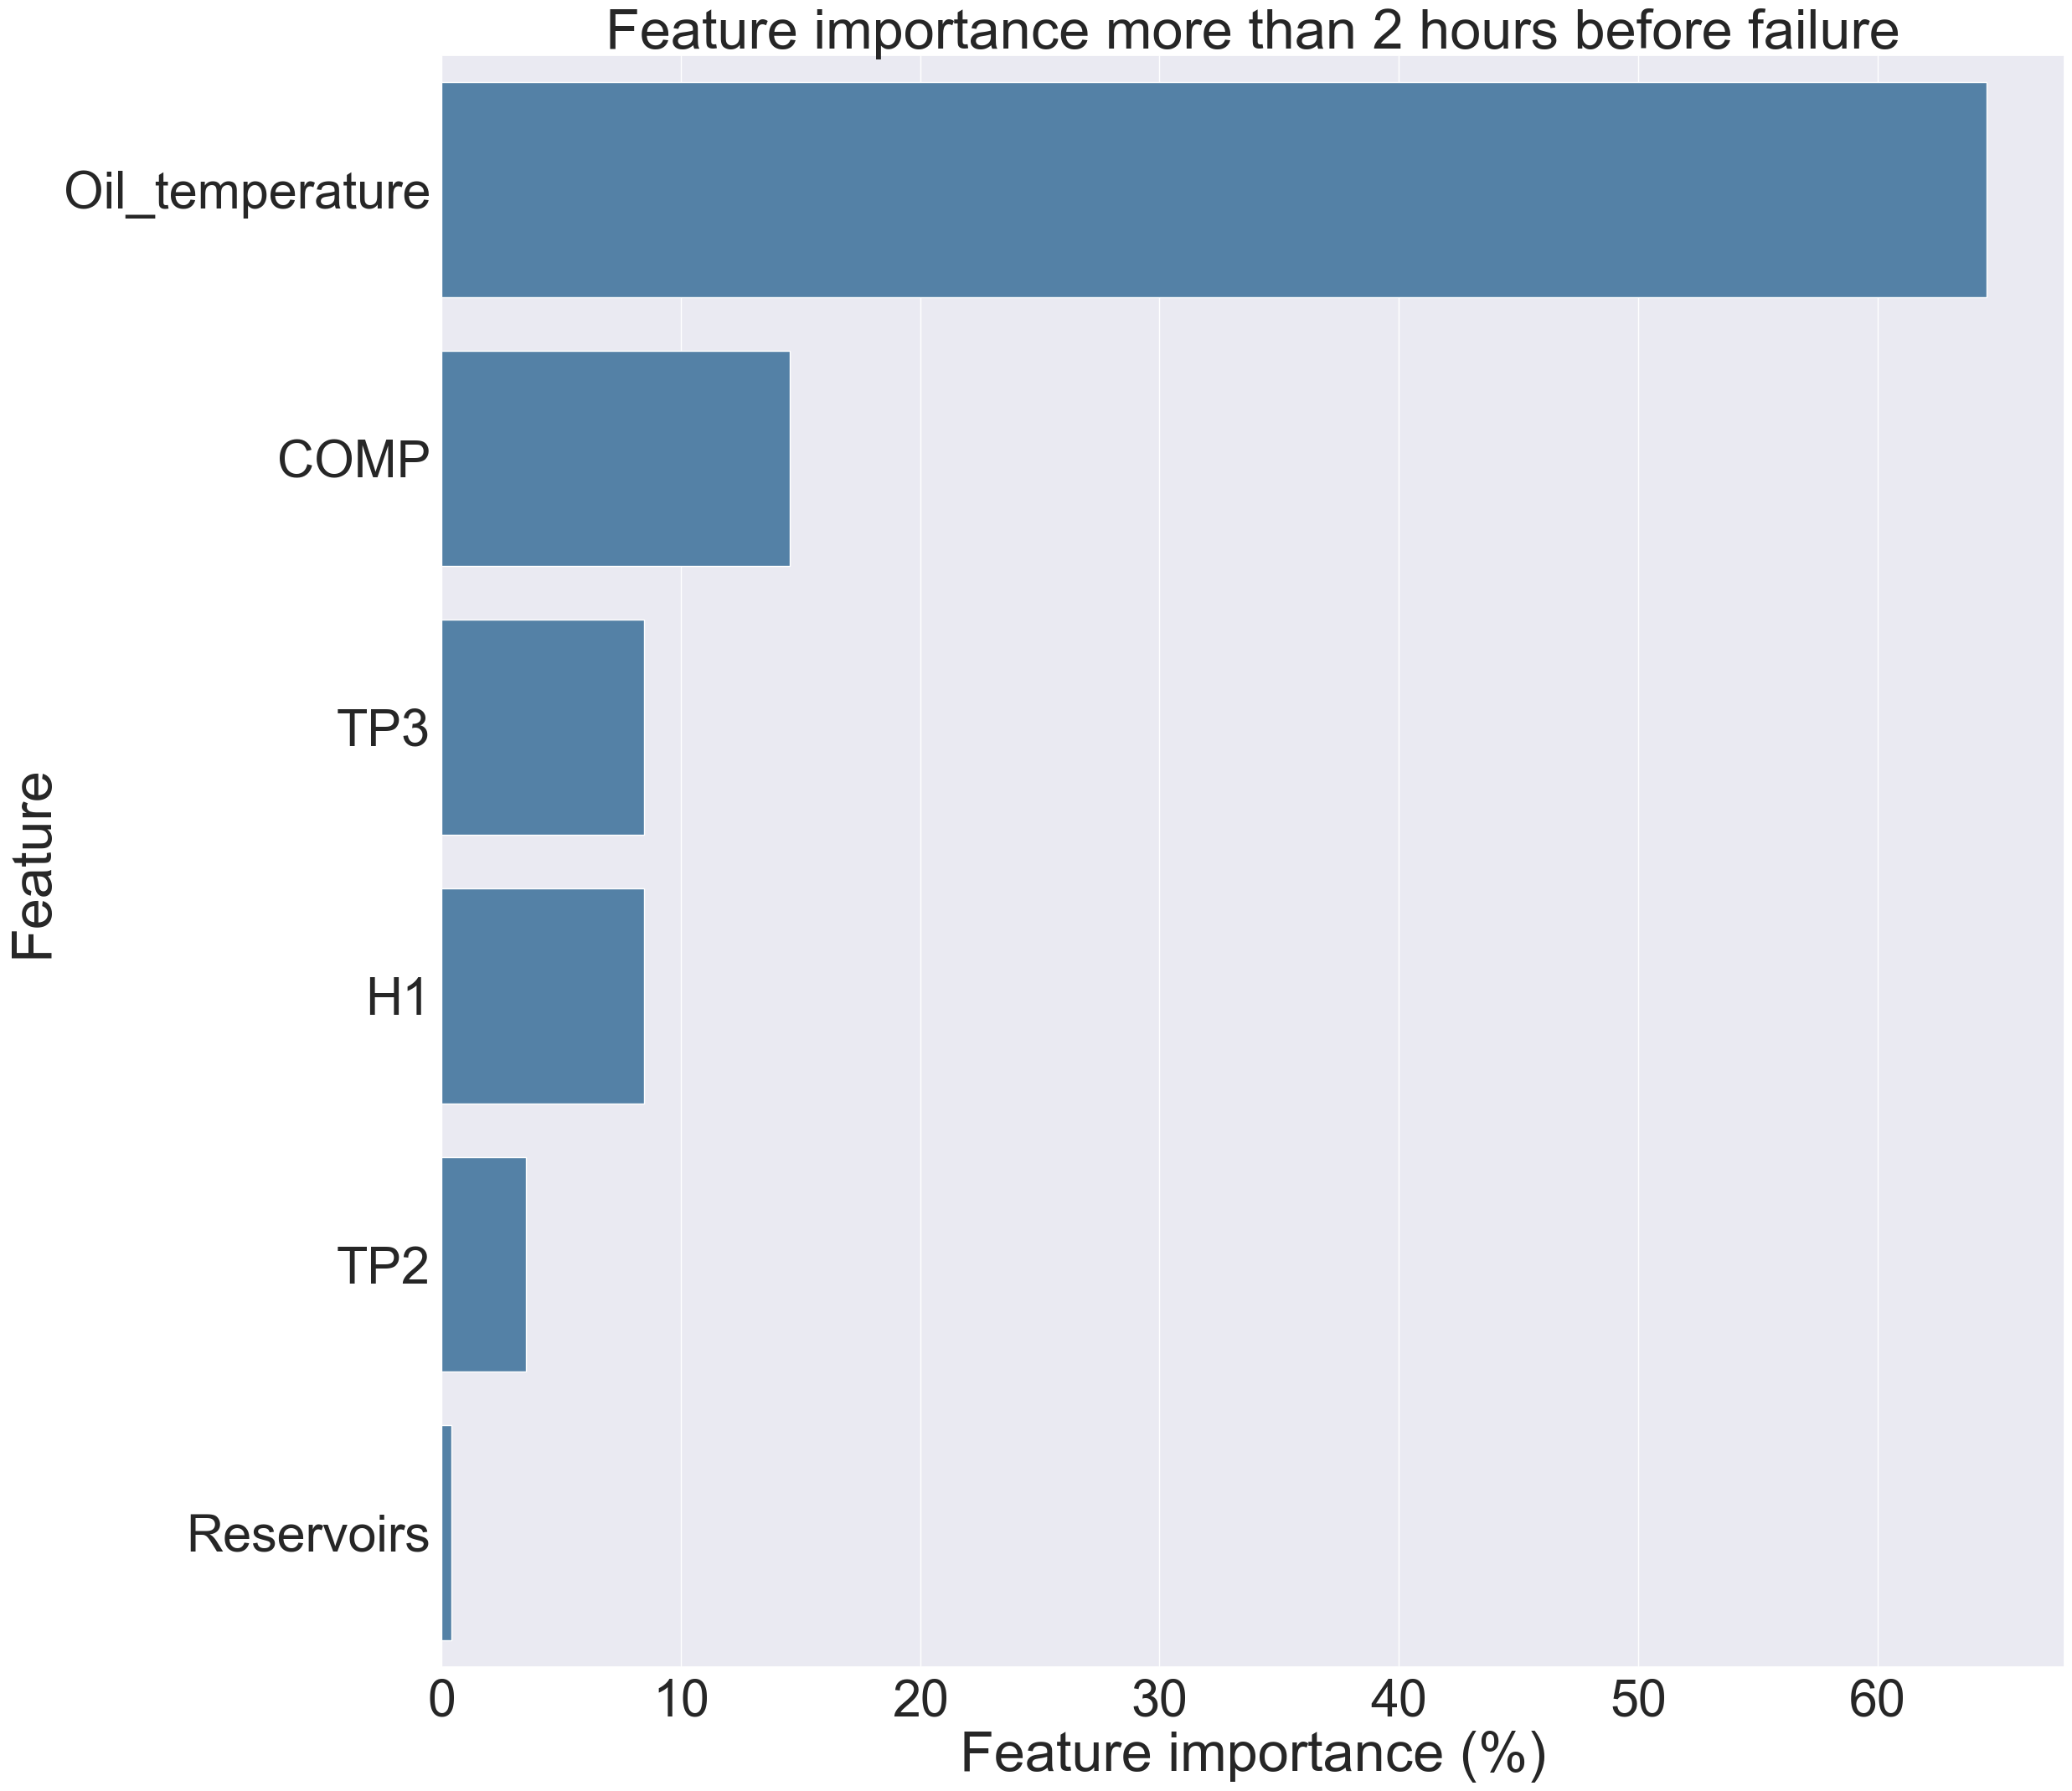

In [81]:
feature_data_for_plot = feature_importance_2_mean.reset_index()
feature_data_for_plot['feature'] = feature_data_for_plot['feature'].map(feature_names_map)
feature_data_for_plot['pct'] = (abs(feature_data_for_plot['value']) / abs(feature_data_for_plot['value']).sum()) * 100
plt.figure(figsize=(25,25))
s = sns.barplot(x='pct', y='feature', data=feature_data_for_plot.sort_values(by='pct',ascending=False),orient='h',color='steelblue')
s.set_title('Feature importance more than 2 hours before failure')
s.set_xlabel('Feature importance (%)')
s.set_ylabel('Feature')
#feature_data_for_plot[['feature','cumsum']]